In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft

%matplotlib inline
%load_ext autoreload
%autoreload 2

> Początek początku - wczytujemy dane

In [2]:
XY = np.loadtxt('dane.data')
print(XY[0])
print(XY.shape)

[-10.   -3.    2.   -1.   47.   -1.   17.  244.6]
(1999, 8)


> Teraz możemy sobie popatrzeć na dane

In [3]:
df = pd.DataFrame(data=XY, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])

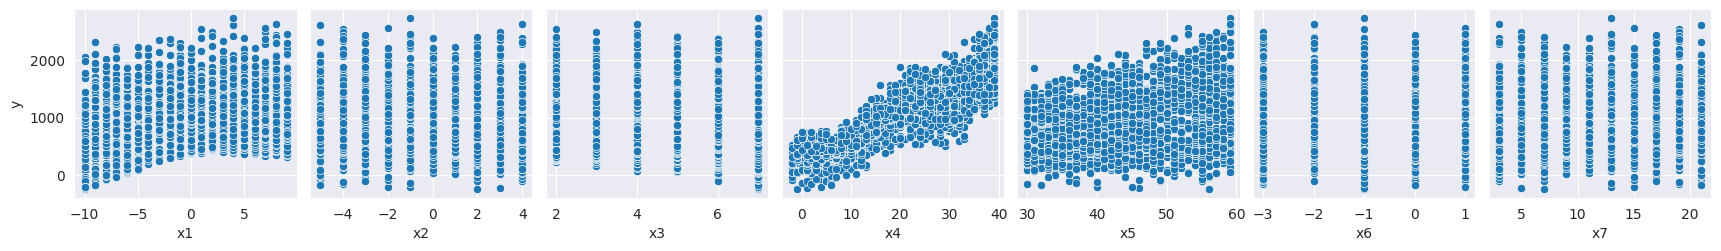

In [4]:
grid = sns.pairplot(df, x_vars=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], y_vars=['y'])

<Axes: >

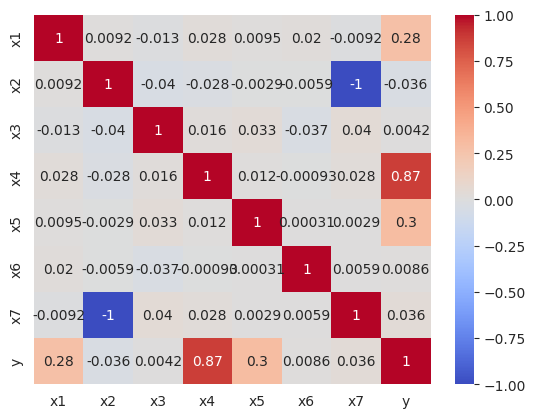

In [5]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

> Coś tam widać \
> Ale czy to nas obchodzi? Na razie nie. Lecimy z najbardziej basic regresją

In [6]:
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
K = 3000
STEPS_TO_PLOT = 30
EPSILON = 1e-5

datasets = []
for i in range(T):
    datasets.append(divide_dataset(XY.copy(), fractions_train_val_test=[0.6, 0.2, 0.2]))

> Mamy 10 losowań. Zobaczmy co nam wyjdzie

In [7]:
from utilz import run_linear_regression_model
from linear_regression import basic_linear_regression
from loss import ols

theta, error, history = run_linear_regression_model(
    ft.partial(basic_linear_regression, bias=False, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=False,
    use_validation=False)

print(f"Theta no bias:\n{theta}")
print(f"Error no bias: {error}")

Theta no bias:
[[ 23.71213734]
 [-93.65612753]
 [ -5.45882295]
 [ 38.33233085]
 [ 18.09314566]
 [  2.71137163]
 [-45.48945628]]
Error no bias: 14756.540584275179


100 3001 100
100 200
(30,)


<Axes: xlabel='Iteration', ylabel='Error'>

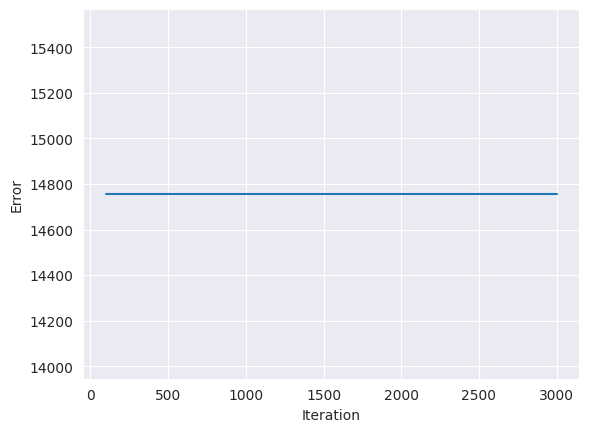

In [9]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)
data = pd.DataFrame({'Iteration': steps, 'Error': history})
sns.lineplot(data=data, x='Iteration', y='Error')

In [28]:
theta_bias, error_bias, history_bias = run_linear_regression_model(
    ft.partial(basic_linear_regression, bias=True, steps=STEPS_TO_PLOT),
    ols, datasets,
    bias=True,
    use_validation=False)
print(f"Theta bias:\n{theta_bias}")
print(f"Error bias: {error_bias}")

Theta bias:
[[-20.32395893]
 [ 23.71213734]
 [-89.96086227]
 [ -5.45882295]
 [ 38.33233085]
 [ 18.09314566]
 [  2.71137163]
 [-43.64182365]]
Error bias: 14756.540584275144


<Axes: xlabel='Iteration', ylabel='Error'>

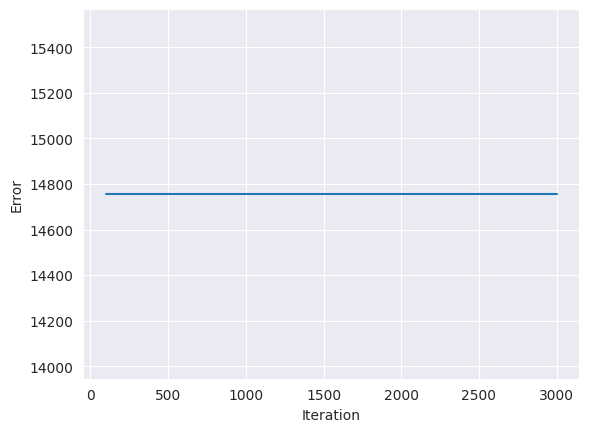

In [29]:
data = pd.DataFrame({'Iteration': steps, 'Error': history})
sns.lineplot(data=data, x='Iteration', y='Error')

> Ten error jest przerażający, ale to przez OLS \
> Co mnie bardziej niepokoi, to że nie ma różnicy między bias=True i bias=False \
> Zobaczmy co na to scikit-learn

In [11]:
from utilz import run_linear_regression_model
from sklearn.linear_model import LinearRegression
from loss import ols

model = LinearRegression(fit_intercept=True)

theta_scikit, error_scikit, _ = run_linear_regression_model(
    lambda X, y, X_val, y_val:
        (np.c_[model.fit(X, y).intercept_, model.coef_].T, []),
    ols,
    datasets,
    bias=True,
    use_validation=False
)

print(f"Theta scikit bias:\n{theta_scikit}")
print(f"Error scikit bias: {error_scikit}")

Theta scikit bias:
[[-512.16376496]
 [  23.71213734]
 [  -0.53544299]
 [  -5.45882295]
 [  38.33233085]
 [  18.09314566]
 [   2.71137163]
 [   1.07088599]]
Error scikit bias: 14756.540584275132


In [12]:
model = LinearRegression(fit_intercept=False)
theta_scikit_no_bias, error_scikit_no_bias, _ = run_linear_regression_model(
    lambda X, y, X_val, y_val: (model.fit(X, y).coef_.T, []),
    ols,
    datasets,
    bias=False,
    use_validation=False)

print(f"Theta scikit no bias:\n{theta_scikit_no_bias}")
print(f"Error scikit no bias: {error_scikit_no_bias}")

Theta scikit no bias:
[[ 23.71213734]
 [-93.65612753]
 [ -5.45882295]
 [ 38.33233085]
 [ 18.09314566]
 [  2.71137163]
 [-45.48945628]]
Error scikit no bias: 14756.540584275124


> Te dane są tak misternie dobrane :| \
> Dalej już będę pisał kod tylko z bias

> Liczymy sobie gradient na 2 sposoby

In [13]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression_finite_diff
from loss import ols

theta_GD_fd, error_GD_fd, _ = run_linear_regression_model(
    ft.partial(GD_linear_regression_finite_diff, alpha=0.0001, k=K, epsilon=EPSILON),
    ols,
    datasets,
    bias=True,
    use_validation=False)

print(f"Theta GD fd:\n{theta_GD_fd}")
print(f"Error GD fd: {error_GD_fd}")

Theta GD fd:
[[ -3.84508713]
 [ 23.85830093]
 [-16.12062242]
 [-13.53877301]
 [ 37.0102042 ]
 [ 11.1804826 ]
 [  3.87842208]
 [-10.05471368]]
Error GD fd: 16887.001307449016


In [19]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from loss import ols

theta_GD, error_GD, history_GD = run_linear_regression_model(
    ft.partial(GD_linear_regression, alpha=0.0001, k=K, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    use_validation=False)

print(f"Theta GD:\n{theta_GD}")
print(f"Error GD: {error_GD}")

Theta GD:
[[ -3.84508714]
 [ 23.85830093]
 [-16.12062243]
 [-13.538773  ]
 [ 37.0102042 ]
 [ 11.1804826 ]
 [  3.87842208]
 [-10.05471368]]
Error GD: 16887.001307370454


<Axes: xlabel='Iteration', ylabel='Error'>

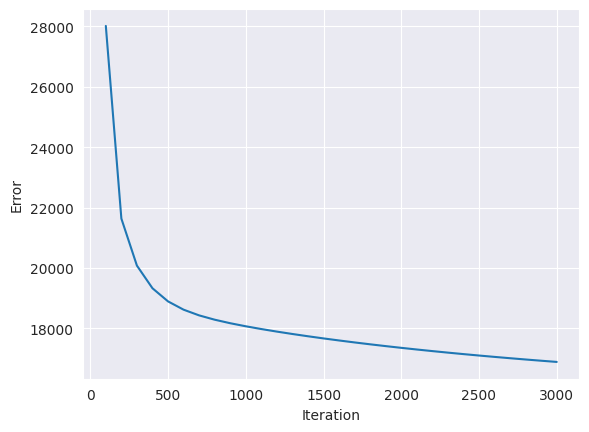

In [26]:
data = pd.DataFrame({'Iteration': steps, 'Error': history_GD})
sns.lineplot(data=data, x='Iteration', y='Error')

> Umiem liczyć gradient :) \
> Wszystko działa jak się da alpha/m z sumą bez mean, inaczej była eksplozja co ma sens

> To teraz czas na SGD

In [23]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols

theta_SGD, error_SGD, history_SGD = run_linear_regression_model(
    ft.partial(SGD_linear_regression, alpha=0.0001, k=K, batch_size=32, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    use_validation=False)

print(f"Theta SGD:\n{theta_SGD}")
print(f"Error SGD: {error_SGD}")

Theta SGD:
[[-20.30748111]
 [ 23.70753742]
 [-89.88081052]
 [ -5.48050689]
 [ 38.33560141]
 [ 18.07057269]
 [  2.72428529]
 [-43.62067119]]
Error SGD: 14862.040309863416


<Axes: xlabel='Iteration', ylabel='Error'>

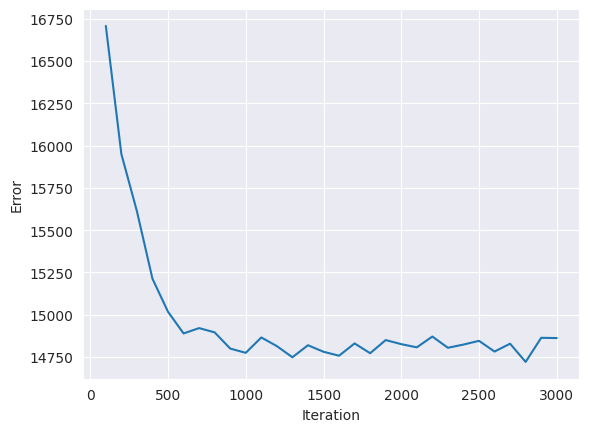

In [25]:
data = pd.DataFrame({'Iteration': steps, 'Error': history_SGD})
sns.lineplot(data=data, x='Iteration', y='Error')

> WOWOWO SGD jest świetny, prawie minimum

> I teraz łączony wykres

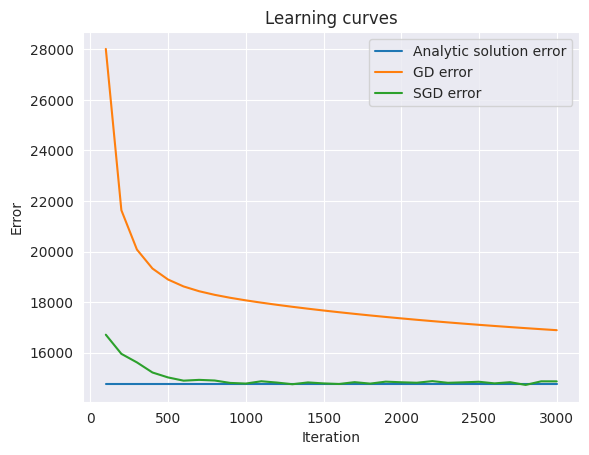

In [30]:
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_bias, ax = ax, label='Analytic solution error')
sns.lineplot(x = steps, y = history_GD, ax = ax, label='GD error')
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

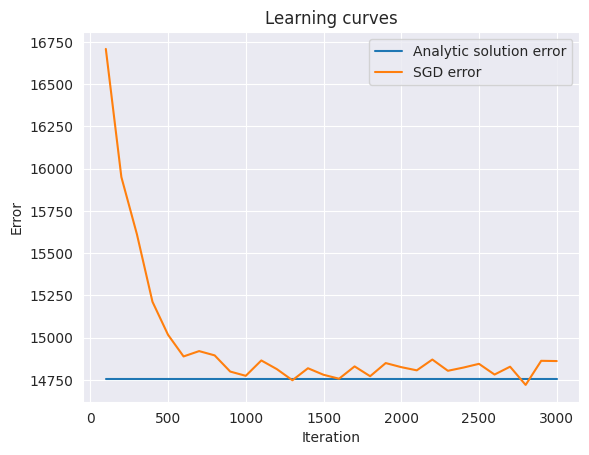

In [31]:
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_bias, ax = ax, label='Analytic solution error')
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Bardzo piękny przykład czemy probabil jest genialny

> TODO: najpierw przeskaluj dane xd i potem od nowa wszystko w dół

> W poszukiwaniu dobrej alphy

In [17]:
from utilz import search_alphas
from linear_regression import GD_linear_regression
from loss import ols

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alphas(ft.partial(GD_linear_regression, k=K), ols, datasets, alphas)

Alpha: 1e-06, loss 56392.024084592485
Alpha: 1e-05, loss 20089.340198091057
Alpha: 0.0001, loss 16693.246102174548
Alpha: 0.001, loss nan
Alpha: 0.01, loss nan
Alpha: 0.1, loss nan


In [20]:
from utilz import search_alphas
from linear_regression import GD_linear_regression
from loss import ols

alphas = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
search_alphas(ft.partial(GD_linear_regression, k=K), ols, datasets, alphas)

Alpha: 0.0002, loss 15898.051673930622
Alpha: 0.0003, loss 15426.171123677766
Alpha: 0.0004, loss 15104.369562505797
Alpha: 0.0005, loss 14879.309201026967
Alpha: 0.0006, loss 14721.18764493673
Alpha: 0.0007, loss 14609.882943927933
Alpha: 0.0008, loss 1.4843089616125067e+185
Alpha: 0.0009, loss nan


> Super mamy alpha dla GD, to teraz SGD

In [23]:
from utilz import search_alphas
from linear_regression import SGD_linear_regression
from loss import ols

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alphas(ft.partial(SGD_linear_regression, k=K, batch_size=32), ols, datasets, alphas)

Alpha: 1e-06, loss 17742.465539290733
Alpha: 1e-05, loss 15192.201986238773
Alpha: 0.0001, loss 14462.71112082396
Alpha: 0.001, loss nan
Alpha: 0.01, loss nan
Alpha: 0.1, loss nan


In [25]:
from utilz import search_alphas
from linear_regression import SGD_linear_regression
from loss import ols

alphas = [0.0002, 0.0003, 0.0004]
search_alphas(ft.partial(SGD_linear_regression, k=K, batch_size=32), ols, datasets, alphas)

Alpha: 0.0002, loss 14359.863061666809
Alpha: 0.0003, loss 14644.009412413361
Alpha: 0.0004, loss 14999.204553591675


> Widzimy, że SGD potrzebuje mniejszej alpha \
> A co z batch size?

In [33]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols

batch_sizes = [32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    _, error = run_linear_regression_model(
        ft.partial(SGD_linear_regression, alpha=0.0002, k=K, batch_size=batch_size),
        ols,
        datasets,
        bias=True,
        use_validation=True
    )
    print(f"Batch size: {batch_size}, Error: {error}")

Batch size: 32, Error: 14415.245191607022
Batch size: 64, Error: 14320.790309778304
Batch size: 128, Error: 14345.891741380823
Batch size: 256, Error: 14540.790449054024
Batch size: 512, Error: 15110.392696949488


> TODO: dodaj train error